In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Fig 10: Ablation over Waiting Policies Pareto Curve

In [3]:
# Synthetic helios - 300K jobs, poisson
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/ablate_waiting_policies_pareto.log').expanduser()
waiting_policy_pareto_df = utils.load_logs_as_dataframe(log_path)

In [7]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('linear_runtime', -1, -1): 'Runtime-Wait',
    ('linear_cost', -1, -1): 'Compute-Wait',
    ('linear_capacity', -1, -1): 'Resource-Wait',
    ('zero', -1, -1): 'No-Wait',
    ('linear_capacity', 0.25, 3): 'Star-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Compute-Wait': 'tab:red',
    'Star-Wait': 'tab:purple',
    'Runtime-Wait': 'tab:green',
    'Resource-Wait': 'tab:blue',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        color = color_dict[label]
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, color=color, label = label, legend=None)
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 0.5:
            color = 'tab:orange'
            marker = 'P'
            marker_size = 13
            temp=True
        elif row['waiting_policy_x'] == 'linear_runtime' and row['waiting_factor_x'] == 0.25:
            color = 'tab:green'
            marker = 'X'
            marker_size = 13
            temp=True
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.04:
            color = 'tab:red'
            marker = '*'
            marker_size = 18
            temp=True
        elif row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 0.2 and row['preempt_cloud_ratio_x'] == -1:
            color = 'tab:blue'
            marker = 'o'
            marker_size = 13
            temp=True
        elif row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 0.2 and row['preempt_cloud_ratio_x'] > 0:
            color = 'tab:purple'
            marker = 's'
            marker_size = 12
            temp=True
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    for ax in axs:
        set_plotting_setting(ax)
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
    
    fig.legend([Line2D([0], [0], marker='P', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='Constant-Wait'), \
                Line2D([0], [0], marker='o', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='Resource-Wait'), \
                Line2D([0], [0], marker='s', color='tab:purple', markerfacecolor='tab:purple', \
            markersize=12, markeredgecolor='tab:purple', label='Star-Wait'), \
                 Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=18, markeredgecolor='tab:red', label='Compute-Wait'), \
                Line2D([0], [0], marker='X', color='tab:green', markerfacecolor='tab:green', \
            markersize=13, markeredgecolor='tab:green', label='Runtime-Wait')], \
               labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/waiting_policy_pareto.pdf', bbox_inches='tight')
    plt.show()  

['Constant-Wait', 'Resource-Wait', 'Star-Wait', 'Compute-Wait', 'Runtime-Wait']


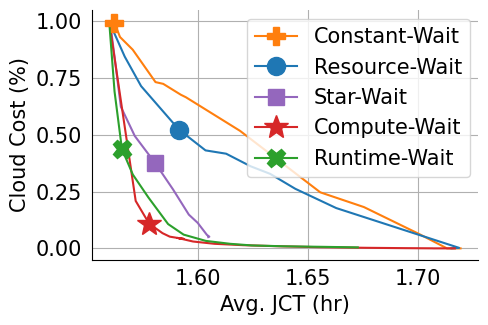

In [8]:
simulator_plotting_fn(waiting_policy_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 1,},
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)

# Fig 10: Ablating Out-of-Order Scheduling Pareto Curve

In [22]:
# Synthetic philly - 300K jobs, poisson
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/ablate_out_of_order_pareto.log').expanduser()
loop_pareto_df = utils.load_logs_as_dataframe(log_path)

In [31]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=3.9, right=4.8)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    ('constant', 0, -1, -1): 'Constant-Wait',
    ('constant', 1, -1, -1): 'Constant-Wait',
    ('zero', 1, -1, -1): 'No-Wait',
    ('linear_cost', 0, -1, -1): 'Compute-Wait',
    ('linear_cost', 1, -1, -1): 'Compute-Wait',
    ('linear_capacity', 0, 0.25, 3): 'Star-Wait',
    ('linear_capacity', 1, 0.25, 3): 'Star-Wait',
}

color_dict = {
    'Constant-Wait': 'tab:orange',
    'Compute-Wait': 'tab:red',
    'Star-Wait': 'tab:blue',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]

    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        # Loop
        if label[1]:
            linestyle='solid'
        else:
            linestyle='dashed'
        label = legend_dict[label]
        color = color_dict[label]
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis],ax = ax, color=color, label = label, linestyle=linestyle, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08 and row['loop_x']==0:
            temp=True
            marker = '*'
            marker_size = 18
            color='tab:red'
        if row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08 and row['loop_x']==1:
            temp=True
            color='tab:red'
            marker = '*'
            marker_size = 18
        if row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 0.8 and row['loop_x']==0:
            temp=True
            marker = 'X'
            marker_size = 13
            color='tab:blue'
        if row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 0.8 and row['loop_x']==1:
            temp=True
            color='tab:blue'
            marker = 'X'
            marker_size = 13
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    from matplotlib.lines import Line2D
    lines, labels = ax.get_legend_handles_labels()
    fig.legend([Line2D([0], [0], marker='X', color='tab:blue', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='No-Loop'), 
                Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=18, markeredgecolor='tab:red', label='Loop')], ['Star-Wait', 'Compute-Wait'], ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.72), framealpha=0.6)
    fig.legend( [Line2D([0], [0], color='black', linestyle='dashed', lw=2), Line2D([0], [0], color='black', linestyle='solid', lw=2)], ['No-OO', 'OO'], ncol=1,loc='upper right', bbox_to_anchor=(0.93, 0.51), framealpha=0.6)
    plt.tight_layout()
    plt.savefig('figures/evaluation/loop_pareto.pdf', bbox_inches='tight')
    plt.show()  

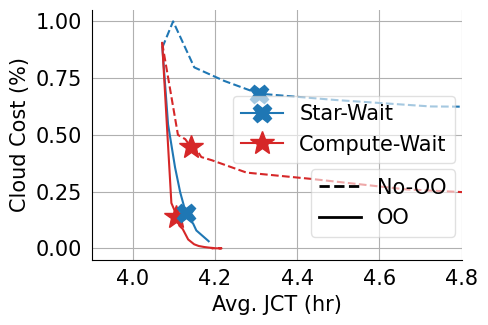

In [32]:
simulator_plotting_fn(loop_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'linear_cost','waiting_factor': 0, 'loop': 0,},
                      groupby_values=['waiting_policy', 'loop', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)